# Предобработка данных для обучения и выбор модели

### Предобработка данных
Загрузим итоговый датасет, который получили при анализе и обработке в плейбке EDA, нормализуем данные и разделим их на обучающую и тестовую выборки.
Выделин в качестве целевого вектора признак "Прочность при растяжении, МПа", значения которого и будет предсказывать модель в дальнейшем.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score


In [2]:
RANDOM_STATE = 42

In [3]:
df = pd.read_csv(r'datasets\cleaned_dataset.csv',index_col=0)

Нормализуем и разобьём датасет на обучающую и тестовую выборки

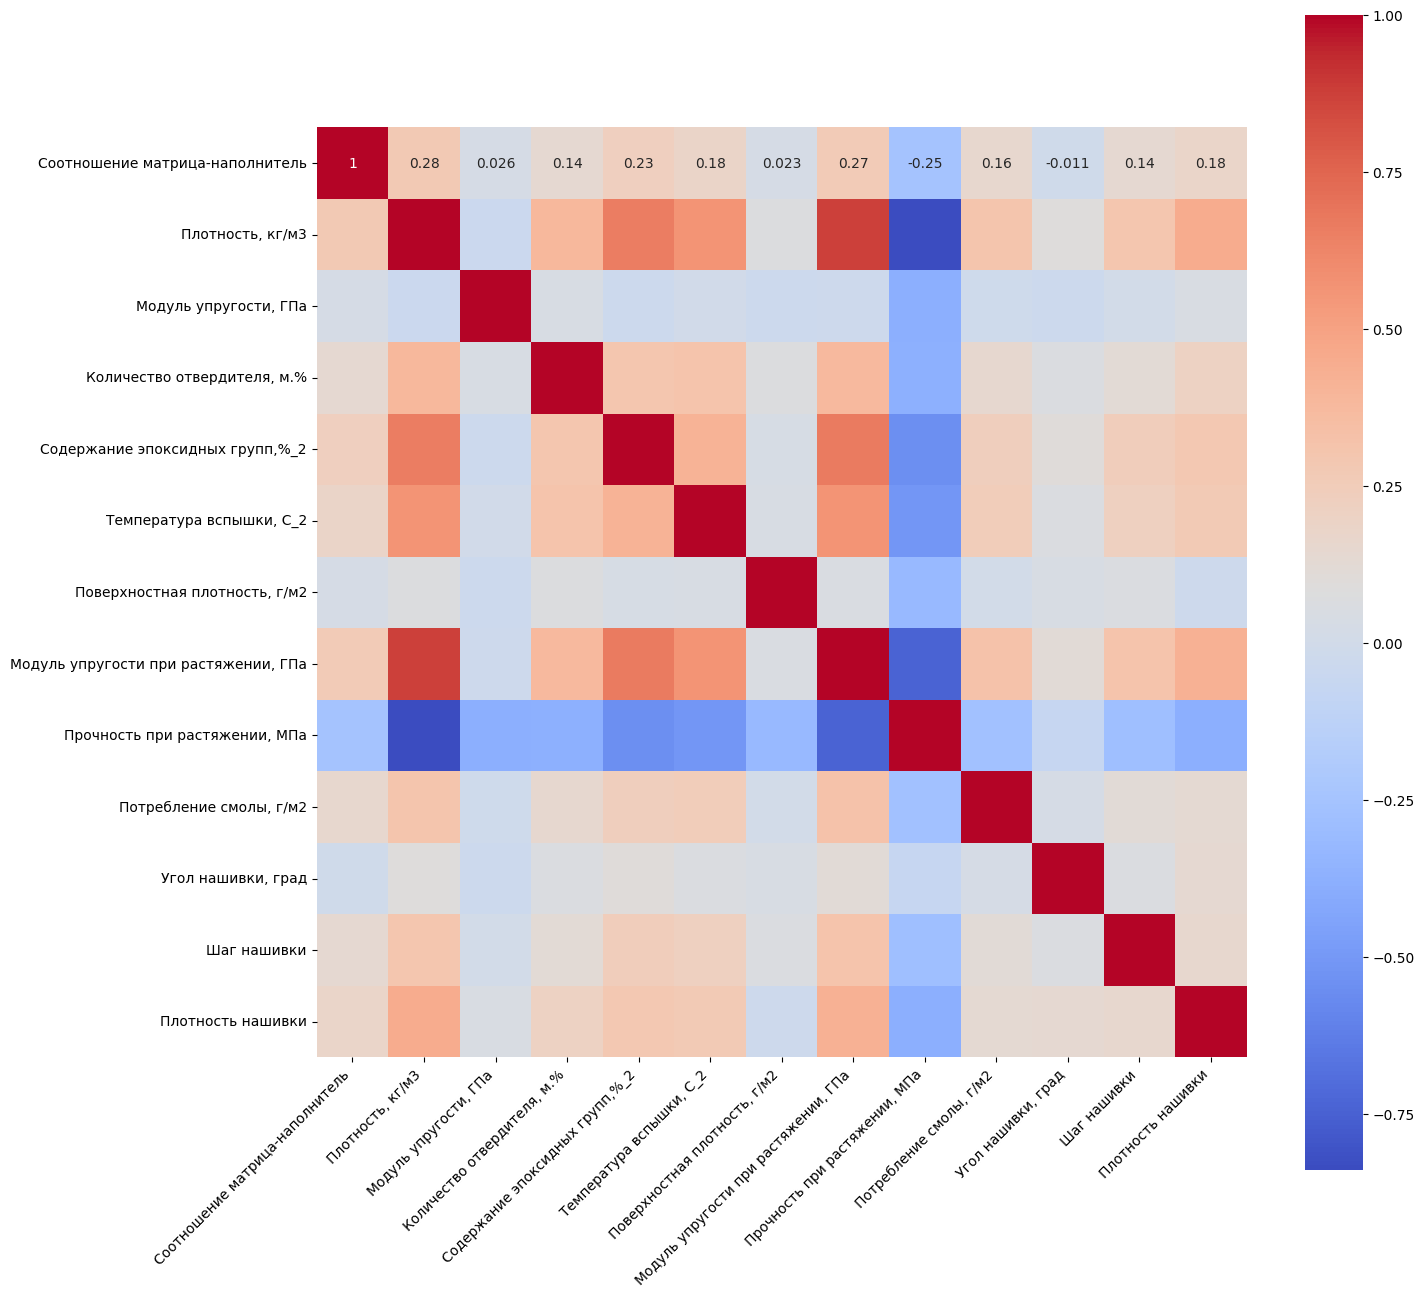

In [4]:
# StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, RobustScaler, QuantileTransformer - не подошли, так как даные показывают очень низкую корреляцию относительно целевых признаков
norm_scaler = Normalizer(norm='l2')
normalized = norm_scaler.fit_transform(df)
df_norm=pd.DataFrame(normalized, columns=df.columns)

# посомтрим на корреляцию после нормализации
plt.figure(figsize=(15,15))
sns.heatmap(df_norm.corr(), cmap='coolwarm', annot=True, square=True)
plt.xticks(rotation=45, ha='right')
plt.show()

# разделим датасет на матрицу объектов признаков и целевые векторы - предсказывать будет параметры 'Прочность при растяжении, МПа' и 'Модуль упругости при растяжении, ГПа'
X=df_norm.loc[:, ~df_norm.columns.isin(['Прочность при растяжении, МПа', 'Модуль упругости при растяжении, ГПа'])]
y=df_norm[['Прочность при растяжении, МПа', 'Модуль упругости при растяжении, ГПа']]

Помимо Normalizer, так же были испробованы различные другие скейлеры из модуля preprocessing: StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, RobustScaler, QuantileTransformer, которые показали очень низкие результаты - коррелиции между признаками практически нету. Попытка создать новые признаки с помощью метода главных компонент (ниже) так же не дало никакого прироста точности.
В итоге остановимся на нормализации, при этом минус нормализации заключается в невозможности обратного преобразования предсказанных значений, поэтому она больше подходит для задач классификации, а не регрессии. 

In [5]:
# X=df.loc[:, ~df.columns.isin(['Прочность при растяжении, МПа', 'Модуль упругости при растяжении, ГПа'])]
# y=df[['Прочность при растяжении, МПа', 'Модуль упругости при растяжении, ГПа']]
# # scaler = StandardScaler()
# x_scaler = MinMaxScaler()
# y_scaler = MinMaxScaler()
# X_scaled = x_scaler.fit_transform(X)
# y = y_scaler.fit_transform(y)
# pca = PCA(n_components=11, random_state=RANDOM_STATE)
# X = pca.fit_transform(X_scaled)

In [6]:
# разбиваем выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Создадим словари перебираемых параметров будущих моделей и ансамблей
Определими функцию, которая с помощью RandomizedSearchCV подберёт оптимальные гиперпараметры для моделей на основе метрик MSE и R²

In [7]:
def randomiz_search(model, params: 'dict', num_iter: 'int', cv: 'int', X, y, random_state=None):
    
    # Используем RandomizedSearchCV для поиска гиперпараметров
    model = RandomizedSearchCV(
        model,
        param_distributions=params,
        n_iter=num_iter,
        verbose=10,
        scoring=['neg_mean_squared_error', 'r2'],
        cv=cv,
        n_jobs=-1,
        refit='neg_mean_squared_error',  # Модель будет оптимизирована по MSE
        random_state=random_state
    )

    # Обучаем модель
    model.fit(X, y)
    
    # Выведем метрики на экран
    best_mse = -model.best_score_  # MSE отрицательное в scoring, поэтому берем отрицание
    mean_r2 = model.cv_results_['mean_test_r2'].mean()  # R² метрика
    
    print("Best MSE:", round(best_mse, 4))
    print("Mean R²:", round(mean_r2, 4))

    return model

Результаты экспериментов будем сохранять отдельно:

In [8]:
results = dict()

### Линейные модели с регуляризацией
Так как у нас имеется сильная зависимость целевых признаков от параметра "Плотность", первой попробуем линейную модель с регуляризацией L1 и L2, которые должна нивелировать импакт от данного параметра на итоговый результат. 

Подбор лучших гиперпарметров для модели.

In [9]:
l1 = Lasso(random_state=RANDOM_STATE)
l1.fit(X_train, y_train)
y_pred = l1.predict(X_test)

# Расчет R2
r2 = r2_score(y_test, y_pred)
print("R² (коэффициент детерминации):", r2)

# Печать первых 5 значений для проверки
print("Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:\n", y_test.values[0:5],'\n\n', y_pred[0:5])

results['Lasso'] = r2

R² (коэффициент детерминации): -0.005060842123434273
Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:
 [[0.83244395 0.01808539]
 [0.54341726 0.02942453]
 [0.79092508 0.02198964]
 [0.7350647  0.02032651]
 [0.75908322 0.02131271]] 

 [[0.73235708 0.02213381]
 [0.73235708 0.02213381]
 [0.73235708 0.02213381]
 [0.73235708 0.02213381]
 [0.73235708 0.02213381]]


In [10]:
l2 = Ridge(random_state=RANDOM_STATE)
l2.fit(X_train, y_train)
y_pred = l2.predict(X_test)

# Расчет R2
r2 = r2_score(y_test, y_pred)
print("R² (коэффициент детерминации):", r2)

# Печать первых 5 значений для проверки
print("Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:\n", y_test.values[0:5],'\n\n', y_pred[0:5])

results['Ridge'] = r2

R² (коэффициент детерминации): 0.8308323796022208
Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:
 [[0.83244395 0.01808539]
 [0.54341726 0.02942453]
 [0.79092508 0.02198964]
 [0.7350647  0.02032651]
 [0.75908322 0.02131271]] 

 [[0.82146755 0.01973361]
 [0.63351988 0.02643888]
 [0.77066086 0.02091725]
 [0.72839856 0.02128966]
 [0.74155491 0.02175453]]


### Модель LinearRegression
Линейная модель без регуляризации.

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Расчет R2
r2 = r2_score(y_test, y_pred)
print("R² (коэффициент детерминации):", r2)

# Печать первых 5 значений для проверки
print("Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:\n", y_test.values[0:5],'\n\n', y_pred[0:5])

results['LinearRegression'] = r2

R² (коэффициент детерминации): 0.8851955098241253
Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:
 [[0.83244395 0.01808539]
 [0.54341726 0.02942453]
 [0.79092508 0.02198964]
 [0.7350647  0.02032651]
 [0.75908322 0.02131271]] 

 [[0.84586919 0.01894638]
 [0.59805943 0.0280322 ]
 [0.7816911  0.0204526 ]
 [0.72997763 0.02113013]
 [0.74523175 0.02153173]]


### Модель DecisionTree
Подбор лучших гиперпараметров для модели

In [12]:
tree_params = {
    'max_depth': range(1, 15)
}

# Поиск лучших парметров
model_tree = randomiz_search(
    DecisionTreeRegressor(
        random_state=RANDOM_STATE
    ), 
    tree_params, 10, 5, X_train, y_train, RANDOM_STATE
)

print("Лучшие гиперпараметры:", model_tree.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best MSE: 0.0002
Mean R²: 0.6888
Лучшие гиперпараметры: {'max_depth': 9}


Обучим модель с лучшими гиперпараметрами и посмотрим результат на тестовой выборке:

In [13]:
dtr = DecisionTreeRegressor(**model_tree.best_params_, random_state=RANDOM_STATE)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)

# Расчет R2
r2 = r2_score(y_test, y_pred)
print("R² (коэффициент детерминации):", r2)

# Печать первых 5 значений для проверки
print("Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:\n", y_test.values[0:5],'\n\n', y_pred[0:5])

results['DecisionTreeRegressor'] = r2

R² (коэффициент детерминации): 0.8073988723462027
Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:
 [[0.83244395 0.01808539]
 [0.54341726 0.02942453]
 [0.79092508 0.02198964]
 [0.7350647  0.02032651]
 [0.75908322 0.02131271]] 

 [[0.82885667 0.01933465]
 [0.62059647 0.02609706]
 [0.80347808 0.0200219 ]
 [0.71498886 0.02113176]
 [0.74726639 0.02221768]]


### Модель RandomForest
Подбор лучших гиперпараметров для модели

In [14]:
forest_params = {
    'n_estimators' : range(100, 400, 50), 
    'max_depth' : range(5, 15, 3),
    'min_samples_split' : (2, 3, 4),
    'min_samples_leaf' : (1, 2, 3, 4)
}

# Поиск лучших парметров
model_forest = randomiz_search(
    RandomForestRegressor(
        random_state=RANDOM_STATE
    ), 
    forest_params, 10, 5, X_train, y_train, RANDOM_STATE
)

print("Лучшие гиперпараметры:", model_forest.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best MSE: 0.0001
Mean R²: 0.8419
Лучшие гиперпараметры: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 11}


Обучим модель с лучшими гиперпараметрами и посмотрим результат на тестовой выборке:

In [15]:
rfr = RandomForestRegressor(**model_tree.best_params_, random_state=RANDOM_STATE)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

# Расчет R2
r2 = r2_score(y_test, y_pred)
print("R² (коэффициент детерминации):", r2)

# Печать первых 5 значений для проверки
print("Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:\n", y_test.values[0:5],'\n\n', y_pred[0:5])

results['RandomForestRegressor'] = r2

R² (коэффициент детерминации): 0.8821718902393726
Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:
 [[0.83244395 0.01808539]
 [0.54341726 0.02942453]
 [0.79092508 0.02198964]
 [0.7350647  0.02032651]
 [0.75908322 0.02131271]] 

 [[0.82772954 0.01913199]
 [0.60289531 0.02678643]
 [0.79143838 0.02014646]
 [0.72714648 0.02118419]
 [0.75262931 0.0219342 ]]


### Модель GradientBoosting
Подбор лучших гиперпараметров для модели. Так как GradientBoostingRegressor может предсказывать значения только одномерного вектора, а наши целевые параметры представлены 2-мерным массивом, то обернём нашу базовую модель в MultiOutputRegressor

In [16]:
# Определение модели которая будет передана в MultiOutputRegressor
grb_estimator = GradientBoostingRegressor(random_state=RANDOM_STATE)

# Парметры для MultiOutputRegressor
multreg_params = {
    'estimator__n_estimators': range(100, 400, 50),
    'estimator__learning_rate': [0.01, 0.1, 0.3],
    'estimator__max_depth': range(3, 5, 10)
}

# Поиск лучших парметров
model_grb = randomiz_search(
    MultiOutputRegressor(grb_estimator), 
    multreg_params, 10, 5, X_train, y_train, RANDOM_STATE
)

print("Лучшие гиперпараметры:", model_grb.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best MSE: 0.0
Mean R²: 0.8285
Лучшие гиперпараметры: {'estimator__n_estimators': 350, 'estimator__max_depth': 3, 'estimator__learning_rate': 0.1}


Обучим модель с лучшими гиперпараметрами и посмотрим результат на тестовой выборке:

In [17]:
grb_params = {
    'n_estimators' : model_grb.best_params_['estimator__n_estimators'],
    'learning_rate' : model_grb.best_params_['estimator__learning_rate'],
    'max_depth' : model_grb.best_params_['estimator__max_depth']
}

grb = MultiOutputRegressor(GradientBoostingRegressor(random_state=RANDOM_STATE, **grb_params))
grb.fit(X_train, y_train)
y_pred = grb.predict(X_test)

# Расчет R2
r2 = r2_score(y_test, y_pred)
print("R² (коэффициент детерминации):", r2)

# Печать первых 5 значений для проверки
print("Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:\n", y_test.values[0:5],'\n\n', y_pred[0:5])

results['GradientBoostingRegressor'] = r2

R² (коэффициент детерминации): 0.8935943661047142
Сверим первые 5 значений тестовой выборки и соответствующие им предсказания модели:
 [[0.83244395 0.01808539]
 [0.54341726 0.02942453]
 [0.79092508 0.02198964]
 [0.7350647  0.02032651]
 [0.75908322 0.02131271]] 

 [[0.82782509 0.01919599]
 [0.56714143 0.02680863]
 [0.79299456 0.02066907]
 [0.7319955  0.02185557]
 [0.75760707 0.02134891]]


## Выводы

In [18]:
results = pd.Series(results)
results

Lasso                       -0.005061
Ridge                        0.830832
LinearRegression             0.885196
DecisionTreeRegressor        0.807399
RandomForestRegressor        0.882172
GradientBoostingRegressor    0.893594
dtype: float64

В ходе разведывательного анализа данных нами были выявлены и устранены пропуски данных, ещё на этапе формирования общего датасета. Далее из даптасета были удалены дубликаты строк, а так же выявлены и очищены выбросы в данных с помощью интерквартильного размаха. Кроме того первичный анализ очищенного датасета показал отсутвие корреляций между признаками, поэтому перед подбором и обучением моделей требовалось дополнительно масштабировать имеющиеся данные.

В качестве методов масштабирования применялись: **Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, RobustScaler, QuantileTransformer**. Так же проводились тесты с понижением размерности датасеты с помощью алгоритма PCA, однако из всех пеерчисленных метов результат дала только нормализация данных с помощью **Normalizer**.

Только после нормализации удалось выявить корреляцию пирзнаков относителдьно целевых параметров **'Прочность при растяжении, МПа'** и **'Модуль упругости при растяжении, ГПа'**, при этом корреляция между самим признаками отсутствует.
Однако из минусов данного подхода следует отметить сложность или невозможность обратного преобразования данных после нормализации, а следовательно и проблемы с интерпритацией полученных предсказаний с помощью моделей.

После предобработки данных была выполнена разбивка на **тренировочную** и **тестовую** выборки для оценки качества моделей на невидимых данных. Основное внимание было уделено тренировочной выборке, которая была подвергнута кроссвалидацией через **RandomizedSearchCV** с целью подбора лучших гиперпараметров моделей. Для оценки качества моделей были выбраны метрики **MSE** и **R²**.

Для поиска оптимальных гиперпараметров моделей применялся **RandomizedSearch**.
Были обучены тренировачной выборке и протестированы на етсовой следующие модели:
- **Lasso**
- **Ridge**
- **LinearRegression**
- **DecisionTreeRegressor**
- **RandomForestRegressor**
- **GradientBostingRegressor**

На практике наиболее точные результаты на метрике **R²** показала ансамблевая модель градиентного бустинга GradientBoostingRegressor, немного худший результат показала обычная модель линейного регрессии LinearRegression.
